### Week 9 Model Submission

**Feature Engineering**

To create user-specific features:
1. Group data by user and rating type.
2. Calculate the count of each rating type per user.
3. Convert these counts into percentages of the total ratings per user.
4. Drop user identifiers before training (identifiers are preserved for predictions).

**Data Engineering**

The first batch dataset is split into three parts:
1. 60% Training set
2. 20% Validation set
3. 20% Test set

Stratified sampling is applied to maintain the class distribution across all subsets.

**Feature Preprocessing**

Feature preprocessing involves a two-stage scaling approach:
1. Initial Scaling: Apply standard scaling to the raw features to normalize their distributions.
2. Polynomial Feature Generation: Generate polynomial features (degree = 2) to capture potential non-linear relationships in the data.
3. Second Scaling: Apply standard scaling again to the polynomial features to ensure all inputs to the logistic regression model are properly normalized.

**Model Training**
A logistic regression model is trained for multi-class classification based on the engineered features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, preprocessing
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize

In [2]:
RANDOM_SEED = 42

In [ ]:
def process_dataset(df, drop_user=True):
    """Process data & get rating counts by each rating type for each user"""
    df = df.copy()
    new_df = df.drop('item', axis=1)
    new_df = new_df.groupby(['user', 'rating']).value_counts().unstack(fill_value=0)
    new_df.columns = [f'count<{x}>' for x in new_df.columns]
    new_df = new_df.reset_index()
    
    # Calculate percentages
    total = new_df[['count<-10>', 'count<0>', 'count<1>', 'count<10>']].sum(axis=1)
    for col in ['count<-10>', 'count<0>', 'count<1>', 'count<10>']:
        new_df[col] = new_df[col] / total
    
    if drop_user:
        new_df = new_df.drop('user', axis=1)
    
    return new_df

def plot_roc_curve(fprs, tprs, roc_aucs, title):
    """Plot ROC curves for multiclass classification"""
    plt.figure()
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(3), colors):
        plt.plot(fprs[i], tprs[i], color=color, 
                label=f'Class{i} (AUC = {roc_aucs[i]:.3f})')
    
    plt.plot([0,1], [0,1], linestyle='--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {title}')
    plt.legend(loc='lower right')
    plt.show()

def make_confusion_matrix(y_true, y_pred):
    """Create and plot normalized confusion matrix"""
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'],
                yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

def evaluate_model(model, X, y):
    """Evaluate model performance using ROC AUC and confusion matrix"""
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)
    y_binarized = label_binarize(y, classes=[0, 1, 2])
    
    # Calculate ROC curves
    fprs, tprs, roc_aucs = {}, {}, {}
    for i in range(3):
        fprs[i], tprs[i], _ = roc_curve(y_binarized[:, i], y_pred_prob[:, i])
        roc_aucs[i] = auc(fprs[i], tprs[i])
    
    plot_roc_curve(fprs, tprs, roc_aucs, 'Model Evaluation')
    make_confusion_matrix(y, y_pred)
    
    return roc_aucs

def train_model(degree=2):
    """Train the model with proper data splitting and preprocessing"""
    # Load and preprocess data
    data = np.load("first_batch_multi_labels.npz")
    XX = pd.DataFrame(data["X"], columns=["user", "item", "rating"])
    yy = pd.DataFrame(data["yy"], columns=["user", "label"])
    
    # Process features
    processed_XX = process_dataset(XX)
    processed_yy = yy.drop('user', axis=1).squeeze()
    
    # Split data into train+val and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(
        processed_XX, processed_yy,
        test_size=0.2,
        random_state=RANDOM_SEED,
        stratify=processed_yy
    )
    
    # Split remaining data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=0.25,
        random_state=RANDOM_SEED,
        stratify=y_temp
    )
    
    # Fit preprocessors on training data only
    scaler = StandardScaler().fit(X_train)
    X_train_norm = scaler.transform(X_train)
    X_val_norm = scaler.transform(X_val)
    X_test_norm = scaler.transform(X_test)
    
    # Create polynomial features using training data only
    poly = PolynomialFeatures(degree=degree).fit(X_train_norm)
    X_train_poly = poly.transform(X_train_norm)
    X_val_poly = poly.transform(X_val_norm)
    X_test_poly = poly.transform(X_test_norm)
    
    # Normalize polynomial features
    poly_scaler = StandardScaler().fit(X_train_poly)
    X_train_poly_norm = poly_scaler.transform(X_train_poly)
    X_val_poly_norm = poly_scaler.transform(X_val_poly)
    X_test_poly_norm = poly_scaler.transform(X_test_poly)
    
    # Train model
    model = linear_model.LogisticRegression(random_state=RANDOM_SEED)
    model.fit(X_train_poly_norm, y_train)
    
    # Evaluate on validation set
    print("Validation Set Performance:")
    val_roc_aucs = evaluate_model(model, X_val_poly_norm, y_val)
    
    # If validation results are satisfactory, retrain on combined train+val data
    X_combined = np.vstack([X_train_poly_norm, X_val_poly_norm])
    y_combined = np.concatenate([y_train, y_val])
    final_model = linear_model.LogisticRegression(random_state=RANDOM_SEED)
    final_model.fit(X_combined, y_combined)
    
    # Final evaluation on test set
    print("\nTest Set Performance:")
    test_roc_aucs = evaluate_model(model, X_test_poly_norm, y_test)
    
    return {
        'model': final_model,
        'scaler': scaler,
        'poly': poly,
        'poly_scaler': poly_scaler,
        'val_roc_aucs': val_roc_aucs,
        'test_roc_aucs': test_roc_aucs
    }

def predict_unseen_data(trained_model_dict):
    """Generate predictions for unseen data using trained model"""
    # Load unseen data
    unseen_data = np.load("second_batch_multi.npz")
    df_X = pd.DataFrame(unseen_data["X"], columns=["user", "item", "rating"])
    
    # Process features
    X_new = process_dataset(df_X, drop_user=False)
    X_new_users = X_new['user'].copy()
    X_new = X_new.drop('user', axis=1)
    
    # Apply same preprocessing steps as training
    X_new_norm = trained_model_dict['scaler'].transform(X_new)
    X_new_poly = trained_model_dict['poly'].transform(X_new_norm)
    X_new_poly_norm = trained_model_dict['poly_scaler'].transform(X_new_poly)
    
    # Generate predictions
    y_pred_prob = trained_model_dict['model'].predict_proba(X_new_poly_norm)
    
    # Create results DataFrame
    df_anomaly_scores = pd.DataFrame({
        'user': X_new_users,
        'z0': y_pred_prob[:, 0],
        'z1': y_pred_prob[:, 1],
        'z2': y_pred_prob[:, 2]
    })
    
    # Save results
    np.savez("cs421-g1-team3-week9.npz", scores=df_anomaly_scores.drop('user', axis=1).to_numpy())
    return df_anomaly_scores

Validation Set Performance:


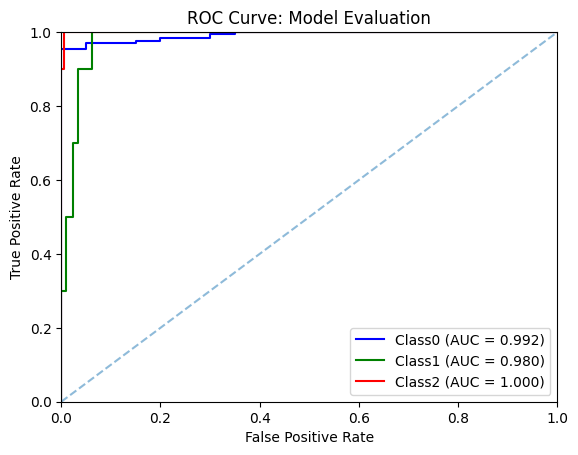

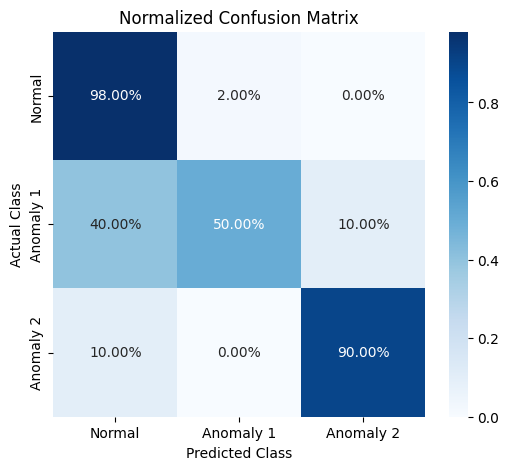


Test Set Performance:


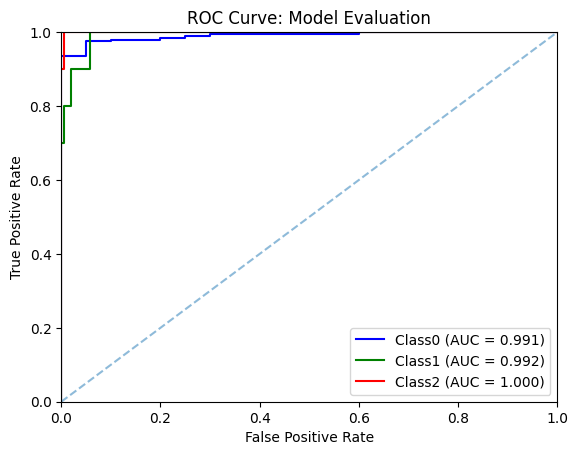

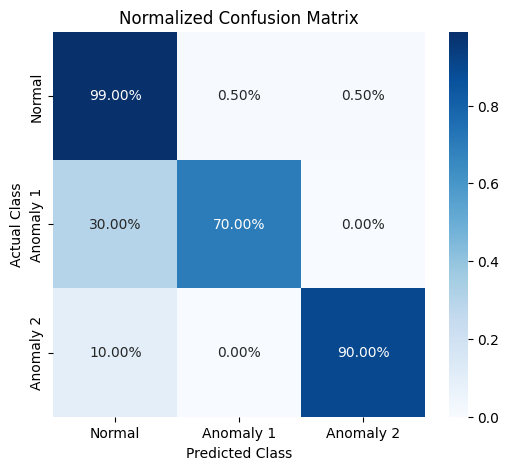


Predictions generated and saved successfully!


In [4]:
# Train model
trained_model = train_model(degree=2)

# Generate predictions for unseen data
predictions = predict_unseen_data(trained_model)
print("\nPredictions generated and saved successfully!")